In [18]:
import numpy as np
import pandas as pd
import os
from os.path import isfile, join, exists
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
import scipy.io as sio
import scipy.stats as stats
from IPython.core.debugger import set_trace
from tqdm import tqdm
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

from pycocotools.coco import COCO

import sklearn
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, PredefinedSplit, StratifiedShuffleSplit, RandomizedSearchCV
from sklearn.svm import SVR, SVC
from sklearn.manifold import MDS
from skimage.transform import resize
import matplotlib.colors as mcolors
import sys

import importlib

from helpers import helpers

importlib.reload(helpers)

<module 'helpers.helpers' from '/user_data/jacobpri/Project/BOLD5000-GLMs/GLMsingle_paper/helpers/helpers.py'>

In [19]:
versions = ['TYPEA_ASSUMEHRF', 'TYPEB_FITHRF', 'TYPEC_FITHRF_GLMDENOISE', 'TYPED_FITHRF_GLMDENOISE_RR']


In [20]:
datasets = ['NSD','B5K']

info = dict()
info['B5K'] = dict()
info['NSD'] = dict()

info['B5K']['subjs'] = ['CSI1','CSI2','CSI3','CSI4']
info['NSD']['subjs'] = ['subj01','subj02','subj03','subj04']

info['methods'] = ['assumehrf', 'fithrf', 'fithrf_glmdenoise', 'fithrf_glmdenoise_rr']

reliability = dict()
masks = np.load('masks.npy',allow_pickle=True).item()

# check to be sure all the datafiles exist
for ds in datasets:
    
    reliability[ds] = dict()
    
    for subj in info[ds]['subjs']:
        
        subj_version_list = []
        
        reliability[ds][subj] = dict()
            
        for method in info['methods']:
        
            metric_savefn = f'reliability_data/{ds}_{subj}_{method}_reliability.npy'
            
            rel = np.load(metric_savefn)
            
            mask = masks[ds][subj]==1
            
            if np.ndim(rel) == 3:
                rel = rel[mask==1]
                
            print(ds,method,subj,rel.shape)
            
            reliability[ds][subj][method] = rel
            
            subj_version_list.append(rel)
                       
        reliability[ds][subj]['mean'] = np.mean(np.stack(subj_version_list,axis=1),axis=1)
        
        

NSD assumehrf subj01 (29723,)
NSD fithrf subj01 (29723,)
NSD fithrf_glmdenoise subj01 (29723,)
NSD fithrf_glmdenoise_rr subj01 (29723,)
NSD assumehrf subj02 (25655,)
NSD fithrf subj02 (25655,)
NSD fithrf_glmdenoise subj02 (25655,)
NSD fithrf_glmdenoise_rr subj02 (25655,)
NSD assumehrf subj03 (28033,)
NSD fithrf subj03 (28033,)
NSD fithrf_glmdenoise subj03 (28033,)
NSD fithrf_glmdenoise_rr subj03 (28033,)
NSD assumehrf subj04 (23155,)
NSD fithrf subj04 (23155,)
NSD fithrf_glmdenoise subj04 (23155,)
NSD fithrf_glmdenoise_rr subj04 (23155,)
B5K assumehrf CSI1 (17116,)
B5K fithrf CSI1 (17116,)
B5K fithrf_glmdenoise CSI1 (17116,)
B5K fithrf_glmdenoise_rr CSI1 (17116,)
B5K assumehrf CSI2 (17481,)
B5K fithrf CSI2 (17481,)
B5K fithrf_glmdenoise CSI2 (17481,)
B5K fithrf_glmdenoise_rr CSI2 (17481,)
B5K assumehrf CSI3 (15954,)
B5K fithrf CSI3 (15954,)
B5K fithrf_glmdenoise CSI3 (15954,)
B5K fithrf_glmdenoise_rr CSI3 (15954,)
B5K assumehrf CSI4 (16707,)
B5K fithrf CSI4 (16707,)
B5K fithrf_glmdenoi

In [21]:
special_B5K_cocos = np.concatenate(np.array([[268008],
       [ 37823],
       [312003],
       [570785],
       [372775],
       [376643],
       [116603],
       [382890],
       [113449],
       [428691],
       [450864],
       [191686],
       [455657],
       [470907],
       [341033],
       [479035],
       [225383],
       [112805],
       [242631],
       [507789]]))


special_NSD_cocos = np.array(['403535', '300383', '474049', '88835', '543254', '213288', '359337', '559225', 
                              '306249', '38801', '462134', '79111', '580813', '516634', '80987', '364806', '525790',
                              '140590', '292845', '352129', '281575', '284987', '125042', '66253', '95828', '197656', 
                              '559816', '357074', '461187', '468771', '524646', '95176', '428605', '78000', '129060', 
                              '434069', '515508', '430850', '377576', '308950', '280808', '113449', '566201', '369253',
                              '474353', '245999', '413115', '322008', '492627', '237697', '55184', '116603', '407778', 
                              '549301', '264244', '573337', '302588', '376858', '188660', '17967', '474827', '274776', 
                              '501867', '454915', '450903', '345149', '267699', '476481', '7932', '455691', '497797', 
                              '526980', '228565', '151049', '113593', '392556', '262414', '392851', '10743', '10710'])
print(special_B5K_cocos.shape, special_NSD_cocos.shape)


(20,) (80,)


In [22]:
acc_savefn = join('MVPA','clf_accuracies.npy')
mdl_savefn = join('MVPA','clf_models.npy')
mds_savefn = join('MVPA','clf_mds.npy')

rel_versions = ['assumehrf','fithrf','fithrf_glmdenoise','fithrf_glmdenoise_rr']
beta_versions = ['TYPEA_ASSUMEHRF','TYPEB_FITHRF','TYPEC_FITHRF_GLMDENOISE','TYPED_FITHRF_GLMDENOISE_RR']
colors = ['dodgerblue','orange','limegreen','tomato']

overwrite = False

min_nvox = 50

if not exists(acc_savefn) or overwrite is True:

    accs = dict()
    models = dict()
    mds = dict()

    for ds in ['NSD','B5K']:

        if ds == 'NSD':
            subjs = [f'subj0{n}' for n in range(1,5)]
        else:
            subjs = [f'CSI{n}' for n in range(1,4)]

        accs[ds] = dict()
        models[ds] = dict()
        mds[ds] = dict()
        
        for subj in subjs:

            mask = masks[ds][subj]
            print(mask.shape)

            accs[ds][subj] = dict()
            models[ds][subj] = dict()
            mds[ds][subj] = dict()

            voxel_reliabilities = reliability[ds][subj]['mean'] 

            for v in range(len(versions)):
                
                beta_version = beta_versions[v]
                rel_version = rel_versions[v]
                
                print(ds,subj,rel_version)

                accs[ds][subj][rel_version] = []
                models[ds][subj][rel_version] = []
                mds[ds][subj][rel_version] = dict()
                mds[ds][subj][rel_version]['mds'] = []

                fn = join(loadbetadir,f'betas_{ds}_{subj}_{beta_version}.npy')

                if not exists(fn):
                    raise ValueError(f'beta file not found:\n{fn}')

                betas = np.load(fn,allow_pickle=True).item()

                cocoIDs = list(betas.keys())
                dims = betas[cocoIDs[0]][0].shape
                mask_nvox = np.sum(mask==1)
                print(f'n vox in mask: {mask_nvox}')

                if np.logical_and(ds == 'B5K', subj != 'CSI4'):
                    nreps = 4
                else:
                    nreps = 3
                    
                print(subj, nreps)
                
                if ds == 'NSD':
                    rep_cocoIDs = []

                    for coco in cocoIDs:
                        if len(betas[coco]) >= nreps:
                            rep_cocoIDs.append(coco)
                
                elif ds == 'B5K':
                    rep_cocoIDs = list(special_B5K_cocos)

                X = np.empty((nreps, len(rep_cocoIDs), mask_nvox))
                X[:] = np.nan
                print(X.shape)

                for rep in range(nreps):
                    for img in range(len(rep_cocoIDs)):
                        X[rep, img] = betas[rep_cocoIDs[img]][rep][mask==1]

                ################################################################

                rel_thresholds = np.array([-1, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4])

                for rel_thresh in rel_thresholds: 

                    # use the remaining half of the images for classification
                    # all reps available, only the remaining half of images, and only the voxels that satisfy rel_thresh
                    X_clf = X[:,:,voxel_reliabilities > rel_thresh]

                    X_clf_rdm = squareform(pdist(np.nanmean(X_clf,axis=0),'correlation'))

                    embedding = MDS(n_components=2, 
                                    random_state=365, 
                                    dissimilarity='precomputed')

                    X_mds = embedding.fit_transform(X_clf_rdm)
                    print(X_mds.shape)

                    mds[ds][subj][rel_version]['mds'].append(X_mds)
                    mds[ds][subj][rel_version]['cocoIDs'] = rep_cocoIDs

                    N_img = X_clf[0].shape[0]
                    N_vox = X_clf[0].shape[1]
                    
                    if N_vox > min_nvox:

                        cv_results = []

                        for test_rep in range(nreps):

                            # train on all reps other than the rest rep
                            train_reps = np.setdiff1d(range(nreps),test_rep)
                            X_train = X_clf[train_reps].reshape(-1,X_clf.shape[2])

                            # ...to predict the test rep image
                            X_test = X_clf[test_rep]

                            # get rid of any voxels with NaN
                            badidx = np.unique(np.concatenate((np.unique(np.argwhere(X_train != X_train)[:,1]),
                                                              np.unique(np.argwhere(X_test != X_test)[:,1]))))
                            goodidx = np.setdiff1d(np.array(range(X_train.shape[1])),badidx)

                            X_train = X_train[:,goodidx]
                            X_test = X_test[:,goodidx]

                            y_train = np.tile(np.array(range(N_img)),nreps-1)
                            y_test = np.array(range(N_img))

                            print(X_train.shape, X_test.shape)
                            print(y_train.shape, y_test.shape)

                            mdl = 'SVM'

                            if mdl == 'SVM':
                                svm_c = 1
                                svm_kernel = 'linear'
                                svm_gamma = 0.1

                                clf = SVC(kernel=svm_kernel,C = svm_c,gamma = svm_gamma)
                                clf_str = mdl + '_' + svm_kernel + '_C_' + str(svm_c).replace('.','_') + '_gamma_' + str(svm_gamma).replace('.','_')

                            elif mdl == 'GBC':
                                gbc_tol = 0.01
                                clf = ensemble.GradientBoostingClassifier(tol=gbc_tol)
                                clf_str = mdl + '_tol_' + str(gbc_tol).replace('.','_')

                            elif mdl == 'RFC':
                                n_est = 100
                                clf = RandomForestClassifier(n_estimators=n_est)
                                clf_str = mdl + '_n_est_' + str(n_est).replace('.','_')

                            clf.fit(X_train,y_train)
                            preds = clf.predict(X_test)

                            result = preds == y_test

                            cv_results.append(result)

                        print(f'{subj} {rel_version} acc = {np.round(np.mean(np.concatenate(cv_results)),3)}, chance = {np.round(1/N_img,3)}, n classes = {N_img}, rel = {rel_thresh}, nvox = {X_clf.shape[2]}\n')

                        accs[ds][subj][rel_version].append(np.mean(np.concatenate(cv_results)))
                        models[ds][subj][rel_version].append(clf)
                        
                    else:
                        accs[ds][subj][rel_version].append(np.nan)
                        models[ds][subj][rel_version].append(np.nan)
                    
    np.save(acc_savefn,accs,allow_pickle=True)
    np.save(mdl_savefn,models,allow_pickle=True)
    np.save(mds_savefn,mds,allow_pickle=True)
    
else:
    accs = np.load(acc_savefn,allow_pickle=True).item()
    models = np.load(mdl_savefn,allow_pickle=True).item()
    mds = np.load(mds_savefn,allow_pickle=True).item()


/home/jacobpri/Gating/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice


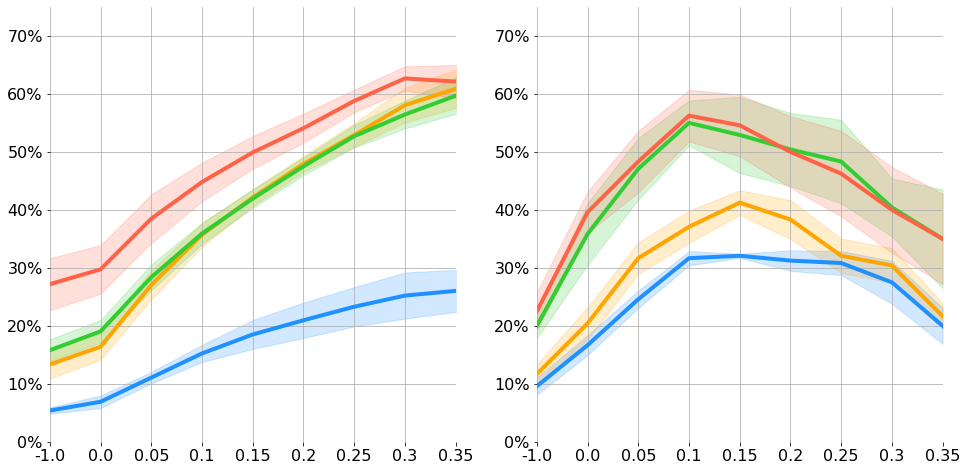

In [23]:
rel_thresholds = np.array([-1, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4])

colors = ['dodgerblue','orange','limegreen','tomato']
plot_versions = rel_versions
s=1
plt.figure(figsize=(16,8))
for ds in ['NSD','B5K']:
    plt.subplot(1,2,s)
    c=0
    for version in plot_versions:
        plot_data = []
        if ds == 'NSD':
            subjs = [f'subj0{n}' for n in range(1,5)]
        else:
            subjs = [f'CSI{n}' for n in range(1,4)]

        for subj in subjs:
            plot_data.append(accs[ds][subj][version])
            
        plot_mean = np.nanmean(np.stack(plot_data,axis=1),axis=1)
        plot_sem = np.nanstd(np.stack(plot_data,axis=1),axis=1) / np.sqrt(len(plot_data))
        
        a = 0.2
        plt.fill_between(np.arange(len(rel_thresholds)),plot_mean - plot_sem, 
                         plot_mean + plot_sem,alpha=a,color=colors[c])


        lalpha = 1
        plt.plot(np.arange(len(rel_thresholds)),plot_mean,
                           linewidth=4,color = colors[c],linestyle = '-',alpha=lalpha)
        
        plt.xticks(np.arange(len(rel_thresholds)), np.array(rel_thresholds), fontsize=16)
        plt.yticks(np.round(np.arange(0,0.8,0.1),1),[f'{x}%' for x in np.arange(0,80,10)],fontsize=16)
        plt.grid('on')
        # get rid of the frame
        for spine in plt.gca().spines.values():
            spine.set_visible(False)
        c+=1
        plt.xlim([0,8])
        plt.ylim([0,0.75])
    s+=1

In [24]:
coco_train_annotations_path = "/lab_data/tarrlab/common/datasets/coco_annotations/instances_train2017.json"
coco_train = COCO(coco_train_annotations_path)

coco_val_annotations_path = '/lab_data/tarrlab/common/datasets/coco_annotations/instances_val2017.json'
coco_val = COCO(coco_val_annotations_path)

catIDs = coco_train.getCatIds()
cats = coco_train.loadCats(catIDs)

supercategs = list(np.unique([x['supercategory'] for x in cats]))
categs = list(np.unique([x['name'] for x in cats]))

print(supercategs, '\n',categs)


loading annotations into memory...
Done (t=19.14s)
creating index...
index created!
loading annotations into memory...
Done (t=0.57s)
creating index...
index created!
['accessory', 'animal', 'appliance', 'electronic', 'food', 'furniture', 'indoor', 'kitchen', 'outdoor', 'person', 'sports', 'vehicle'] 
 ['airplane', 'apple', 'backpack', 'banana', 'baseball bat', 'baseball glove', 'bear', 'bed', 'bench', 'bicycle', 'bird', 'boat', 'book', 'bottle', 'bowl', 'broccoli', 'bus', 'cake', 'car', 'carrot', 'cat', 'cell phone', 'chair', 'clock', 'couch', 'cow', 'cup', 'dining table', 'dog', 'donut', 'elephant', 'fire hydrant', 'fork', 'frisbee', 'giraffe', 'hair drier', 'handbag', 'horse', 'hot dog', 'keyboard', 'kite', 'knife', 'laptop', 'microwave', 'motorcycle', 'mouse', 'orange', 'oven', 'parking meter', 'person', 'pizza', 'potted plant', 'refrigerator', 'remote', 'sandwich', 'scissors', 'sheep', 'sink', 'skateboard', 'skis', 'snowboard', 'spoon', 'sports ball', 'stop sign', 'suitcase', 'sur

In [25]:
# function to plot an image from NSD
def plot_coco(cocoid,border=None,border_width = None, plot=True,dim=None):
    imgfn = f'/lab_data/tarrlab/common/datasets/NSD_images/images/{cocoid}.jpg'
    if not exists(imgfn):
        raise ValueError('image not found')
    else:
        img = np.array(mpimg.imread(imgfn))
        if border is not None:
            img[:border_width,:] = np.array(border)
            img[-border_width:,:] = np.array(border)
            img[:,:border_width] = np.array(border)
            img[:,-border_width:] = np.array(border)
            
        if dim is not None:
            img = resize(img, (dim, dim))
        
        if plot:
            imgplot = plt.imshow(img)
            plt.axis('off') 
    return img, imgfn

def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name'], cats[i]['supercategory']
    return "None"
print('The class name is', getClassName(77, cats))

The class name is ('cell phone', 'electronic')


In [26]:
def get_max_area_categ(anns):
    info = dict()
    info['cat'] = dict()
    info['scat'] = dict()
    
    for a in anns:
        info['cat'][getClassName(a['category_id'], cats)[0]] = []
        info['scat'][getClassName(a['category_id'], cats)[1]] = []
        
    for a in anns:
        cat = getClassName(a['category_id'], cats)[0]
        scat = getClassName(a['category_id'], cats)[1]
        area = a['area']
        info['cat'][cat].append(area)
        info['scat'][scat].append(area)
    
    sums = []
    for key in list(info['cat'].keys()):
        sums.append(np.sum(info['cat'][key]))
    
    max_idx = np.argmax(sums)
    
    max_categ = list(info['cat'].keys())[max_idx]
    max_scateg = coco_size_df.loc[coco_size_df['object (2017)']==max_categ]['supercategory'].values[0]
    
    return max_categ, max_scateg, np.max(sums)


In [27]:
def get_subj_animacy_size(cocoIDs, size_thresh = 6):
    
    animacy = []
    size = []
    max_area_cats = []
    max_area_scats = []
    max_sizes = []
    
    for coco in tqdm(np.array(cocoIDs).astype(int)):
        
        this_cats = []
        this_scats = []
        
        annIds = coco_val.getAnnIds(imgIds=coco)
        anns = coco_val.loadAnns(annIds)
        
        if len(anns) == 0:
            annIds = coco_train.getAnnIds(imgIds=coco)
            anns = coco_train.loadAnns(annIds)
            
        max_area_cat, max_area_scat, max_area_pixels = get_max_area_categ(anns)
            
        max_area_cats.append(max_area_cat)
        max_area_scats.append(max_area_scat)

        if max_area_scat == 'person' or max_area_scat == 'animal':
            animacy.append(True)
        else:
            animacy.append(False)
            
        this_size = coco_size_df.loc[coco_size_df['object (2017)']==max_area_cat]['avg size (ft)'].values[0]
        max_sizes.append(max_area_pixels)
        
        if this_size > size_thresh:
            size.append(True)
        else:
            size.append(False)
            
    labels = []
    for i in range(len(cocoIDs)):
        
        if animacy[i]:
            if size[i]:
                labels.append('big animate')
            else:
                labels.append('small animate')
        else:
            if size[i]:
                labels.append('big inanimate')
            else:
                labels.append('small inanimate')
                
    return labels, max_area_cats, max_area_scats, max_sizes, animacy, size   



In [28]:
def plot_mds(ds, subj, version, rel_idx, method = 'animacy'):
    
    this_mds = mds[ds][subj][version]['mds'][rel_idx]
    
    cocos = mds[ds][subj][version]['cocoIDs'] 
    
    labels, max_area_cats, max_area_scats, max_sizes, animacy, size = get_subj_animacy_size(cocos)
    
    if method == 'animacy':

        unique_labels = np.array(['big animate','small animate','big inanimate','small inanimate'])
        unique_colors = np.array(['lightpink','lightpink','teal','teal'])

        colors = [unique_colors[np.argwhere(unique_labels==x)[0][0]] for x in np.array(labels)]
        
        coco_colors = []

        for x in colors:
            coco_colors.append(np.array(mcolors.to_rgb(x)))
        
    elif method == 'size':
        
        coco_colors = []
        unique_cats = np.unique(max_area_cats)
        unique_sizes = [coco_size_df.loc[coco_size_df['object (2017)']==cat]['log10 avg size'].values[0] for cat in unique_cats]
        size_rankings = np.argsort(unique_sizes)
        ranked_categs = unique_cats[size_rankings]
        
        n_categs = len(size_rankings)

        from matplotlib import cm
        rainbow_colors = np.flipud(np.array(cm.rainbow(range(256)))[:,:3])         

        size_color_dict = dict()
        x = range(0,256,256//n_categs)
        for c,cc in zip(ranked_categs,x):
            size_color_dict[c] = rainbow_colors[cc]

        for cat in max_area_cats:
            coco_colors.append(size_color_dict[cat])

    paths = []

    for coco in cocos:
        _, fn = plot_coco(coco, plot=False)
        paths.append(fn)
          
    x = list(this_mds[:,0])
    y = list(this_mds[:,1])

    idx = range(len(cocos))
    
    c = 0
    for x0, y0, coco in zip(x, y, cocos):
        
        img, _ = plot_coco(coco,border=np.array(coco_colors[c]*255),border_width=60,plot=False,dim=75)
        ab = AnnotationBbox(OffsetImage(img), (x0, y0), frameon=False)
        ax = plt.gca()
        ax.add_artist(ab)
        c+=1

    plt.xlim([-1,1])
    plt.ylim([-1,1])



In [32]:
coco_size_df = pd.read_csv(join('MVPA','COCO_Category_Animacy_Size.csv'))
coco_size_df

,Unnamed: 0,object (paper),object (2014),object (2017),supercategory,avg size (ft),log10 avg size
0,0,person,person,person,person,5.50,0.740363
1,1,bicycle,bicycle,bicycle,vehicle,5.75,0.759668
2,2,car,car,car,vehicle,15.00,1.176091
3,3,motorcycle,motorcycle,motorcycle,vehicle,6.00,0.778151
4,4,airplane,airplane,airplane,vehicle,145.00,2.161368
...,...,...,...,...,...,...,...
86,86,scissors,scissors,scissors,indoor,0.50,-0.301030
87,87,teddy bear,teddy bear,teddy bear,indoor,1.50,0.176091
88,88,hair drier,hair drier,hair drier,indoor,1.00,0.000000
89,89,toothbrush,toothbrush,toothbrush,indoor,0.50,-0.301030


100%|██████████| 82/82 [00:00<00:00, 402.82it/s]


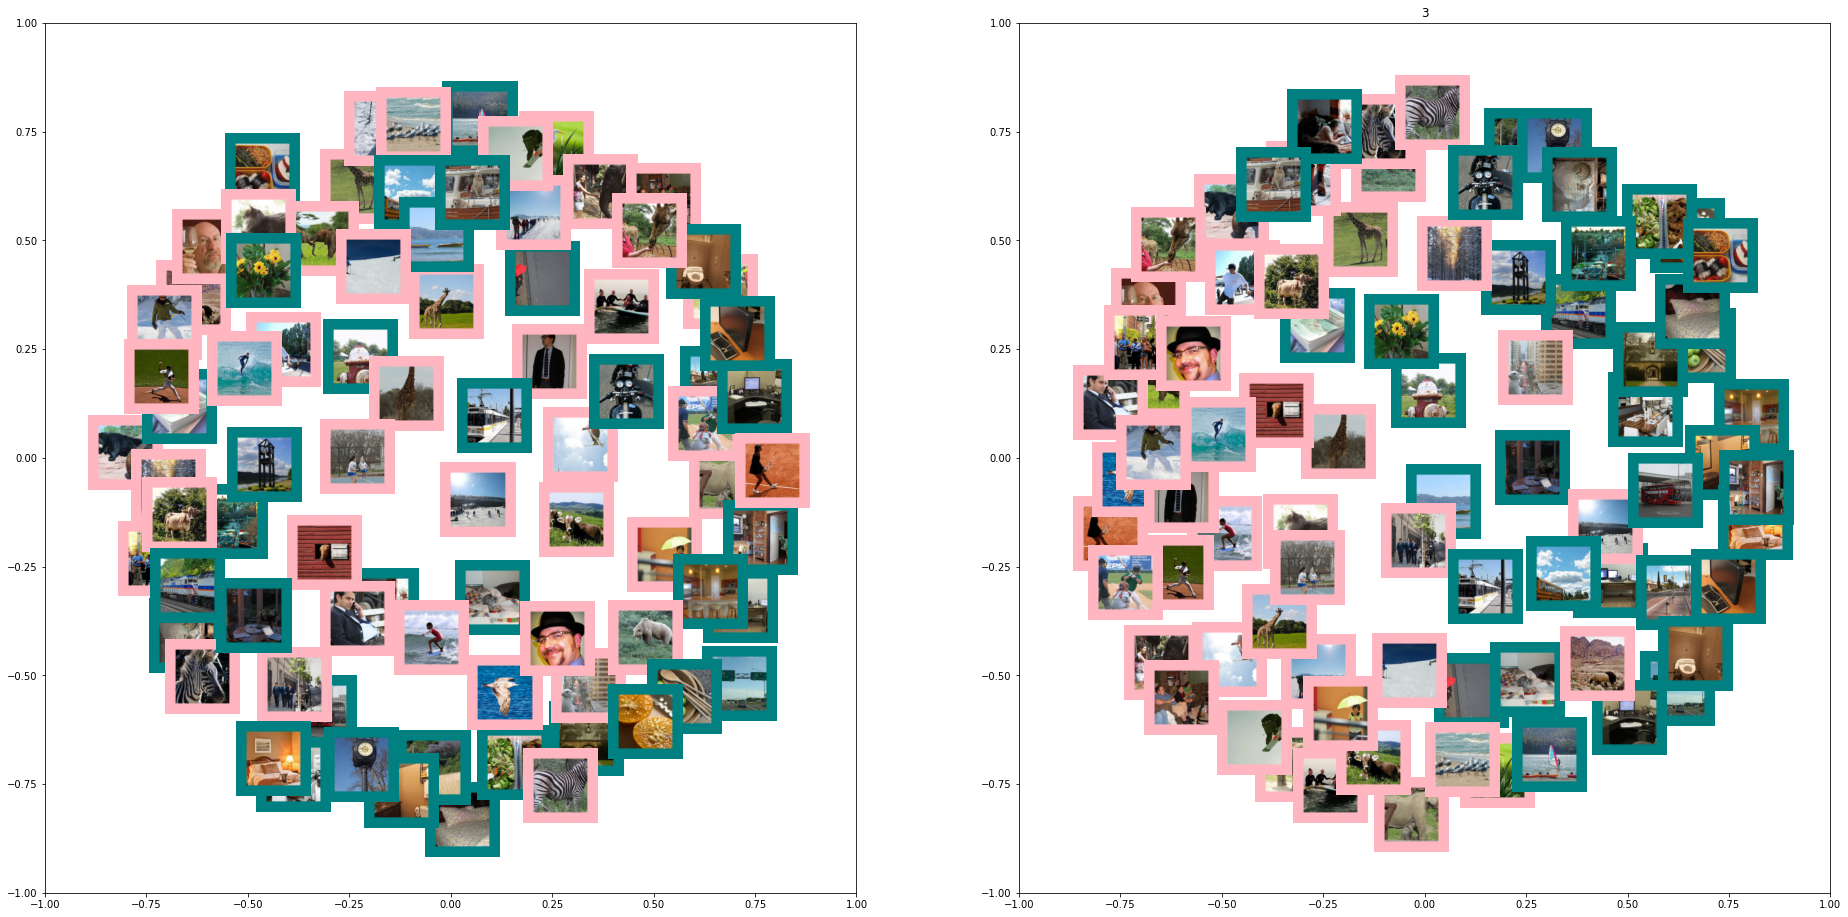

In [16]:
for i in range(3,4):
    plt.figure(figsize=(32,16))
    plt.subplot(121)
    plot_mds('NSD','subj03',rel_versions[0], 0, method = 'animacy')
    plt.subplot(122)
    plot_mds('NSD','subj03',rel_versions[3], 0, method = 'animacy')
    plt.title(i)
    plt.show()
